In [1]:
%load_ext autoreload 
import glob
import nibabel
import numpy as np
import cc3d

import re
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.core.debugger import set_trace
import os
import shutil
from collections import defaultdict
from utils import load
%autoreload 2

In [2]:
def patch_bbox_size(label_tensor):
    
    '''
    label_tensor - np.ndarray, with size: [H,W,D], and values in {0,1}
    '''
    
    labels_out = cc3d.connected_components(label_tensor, connectivity=26)
    u, c = np.unique(labels_out, return_counts=True)
    
    label_info[label]['cc3d'] = [u,c]
        
    mask = labels_out == 1
    
    X,Y,Z = label_tensor.shape
    
    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask]
    
    # fcd center
    center = xyz_grid.mean(0).astype(int)
    
    # fcd bbox sizes
    dx = (np.sum(mask, axis=(1,2)) > 0).sum()
    dy = (np.sum(mask, axis=(0,2)) > 0).sum()
    dz = (np.sum(mask, axis=(0,1)) > 0).sum()
    
    return center, dx,dy,dz

In [9]:
root = '/media/tom/ibulygin/fcd_data/radiologist/'
root_label = os.path.join(root, 'label')

feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii.gz'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii'),
      'bT1':os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'),
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'),
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
      'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates,
                         label_extractor=lambda x: x.split('.')[0],
                         broken_labels={})

No curv for n35
No curv for n68
No curv for n82
No curv for 83
No curv for 88NS
No curv for n61
No curv for 29
No curv for 82
No curv for n70
No curv for n3
No curv for n53
No curv for G256
No curv for 61
No curv for n38
No curv for n55
No curv for 67NS
No curv for 73NS
No curv for n39
No curv for G177
No curv for 63NS
No curv for n46
No curv for 62NS
No curv for 26
No curv for n60
No curv for n58
No curv for n45
No curv for n48
No curv for 65NS
No curv for 69NS
No curv for n73
No curv for 58
No curv for n37
No curv for n64
No curv for n79
No curv for 53
No curv for n75
No curv for n57
No curv for n66
No curv for 84
No curv for n25
No curv for n69
No curv for n81
No curv for n50
No curv for n67
No curv for 74NS
No curv for 51
No curv for n52
No curv for G015
No curv for 81NS
No curv for 87NS
No curv for 79NS
No curv for n63
No curv for n49
No curv for n83
No curv for n56
No curv for n76
No curv for n65
No curv for n77
No curv for n84
No curv for G150
No curv for 50
No curv for n80
No b

In [10]:
len(paths_dict)

80

# Visualization

In [11]:
labels = []
brains = defaultdict(list)

steps = [64,100,-64]
for k,v in tqdm(paths_dict.items()):
    brain = nibabel.load(v['T1w']).get_fdata()
    labels.append(k)
    for step in steps:
        brains[step].append(brain[:,100,:])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:40<00:00,  1.26s/it]


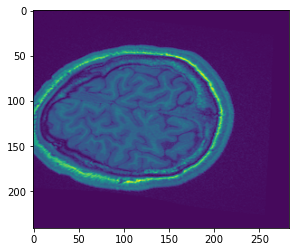

In [22]:
result = load(paths_dict['43'])
plt.imshow(result['T1w'][:,64,:])
plt.show()

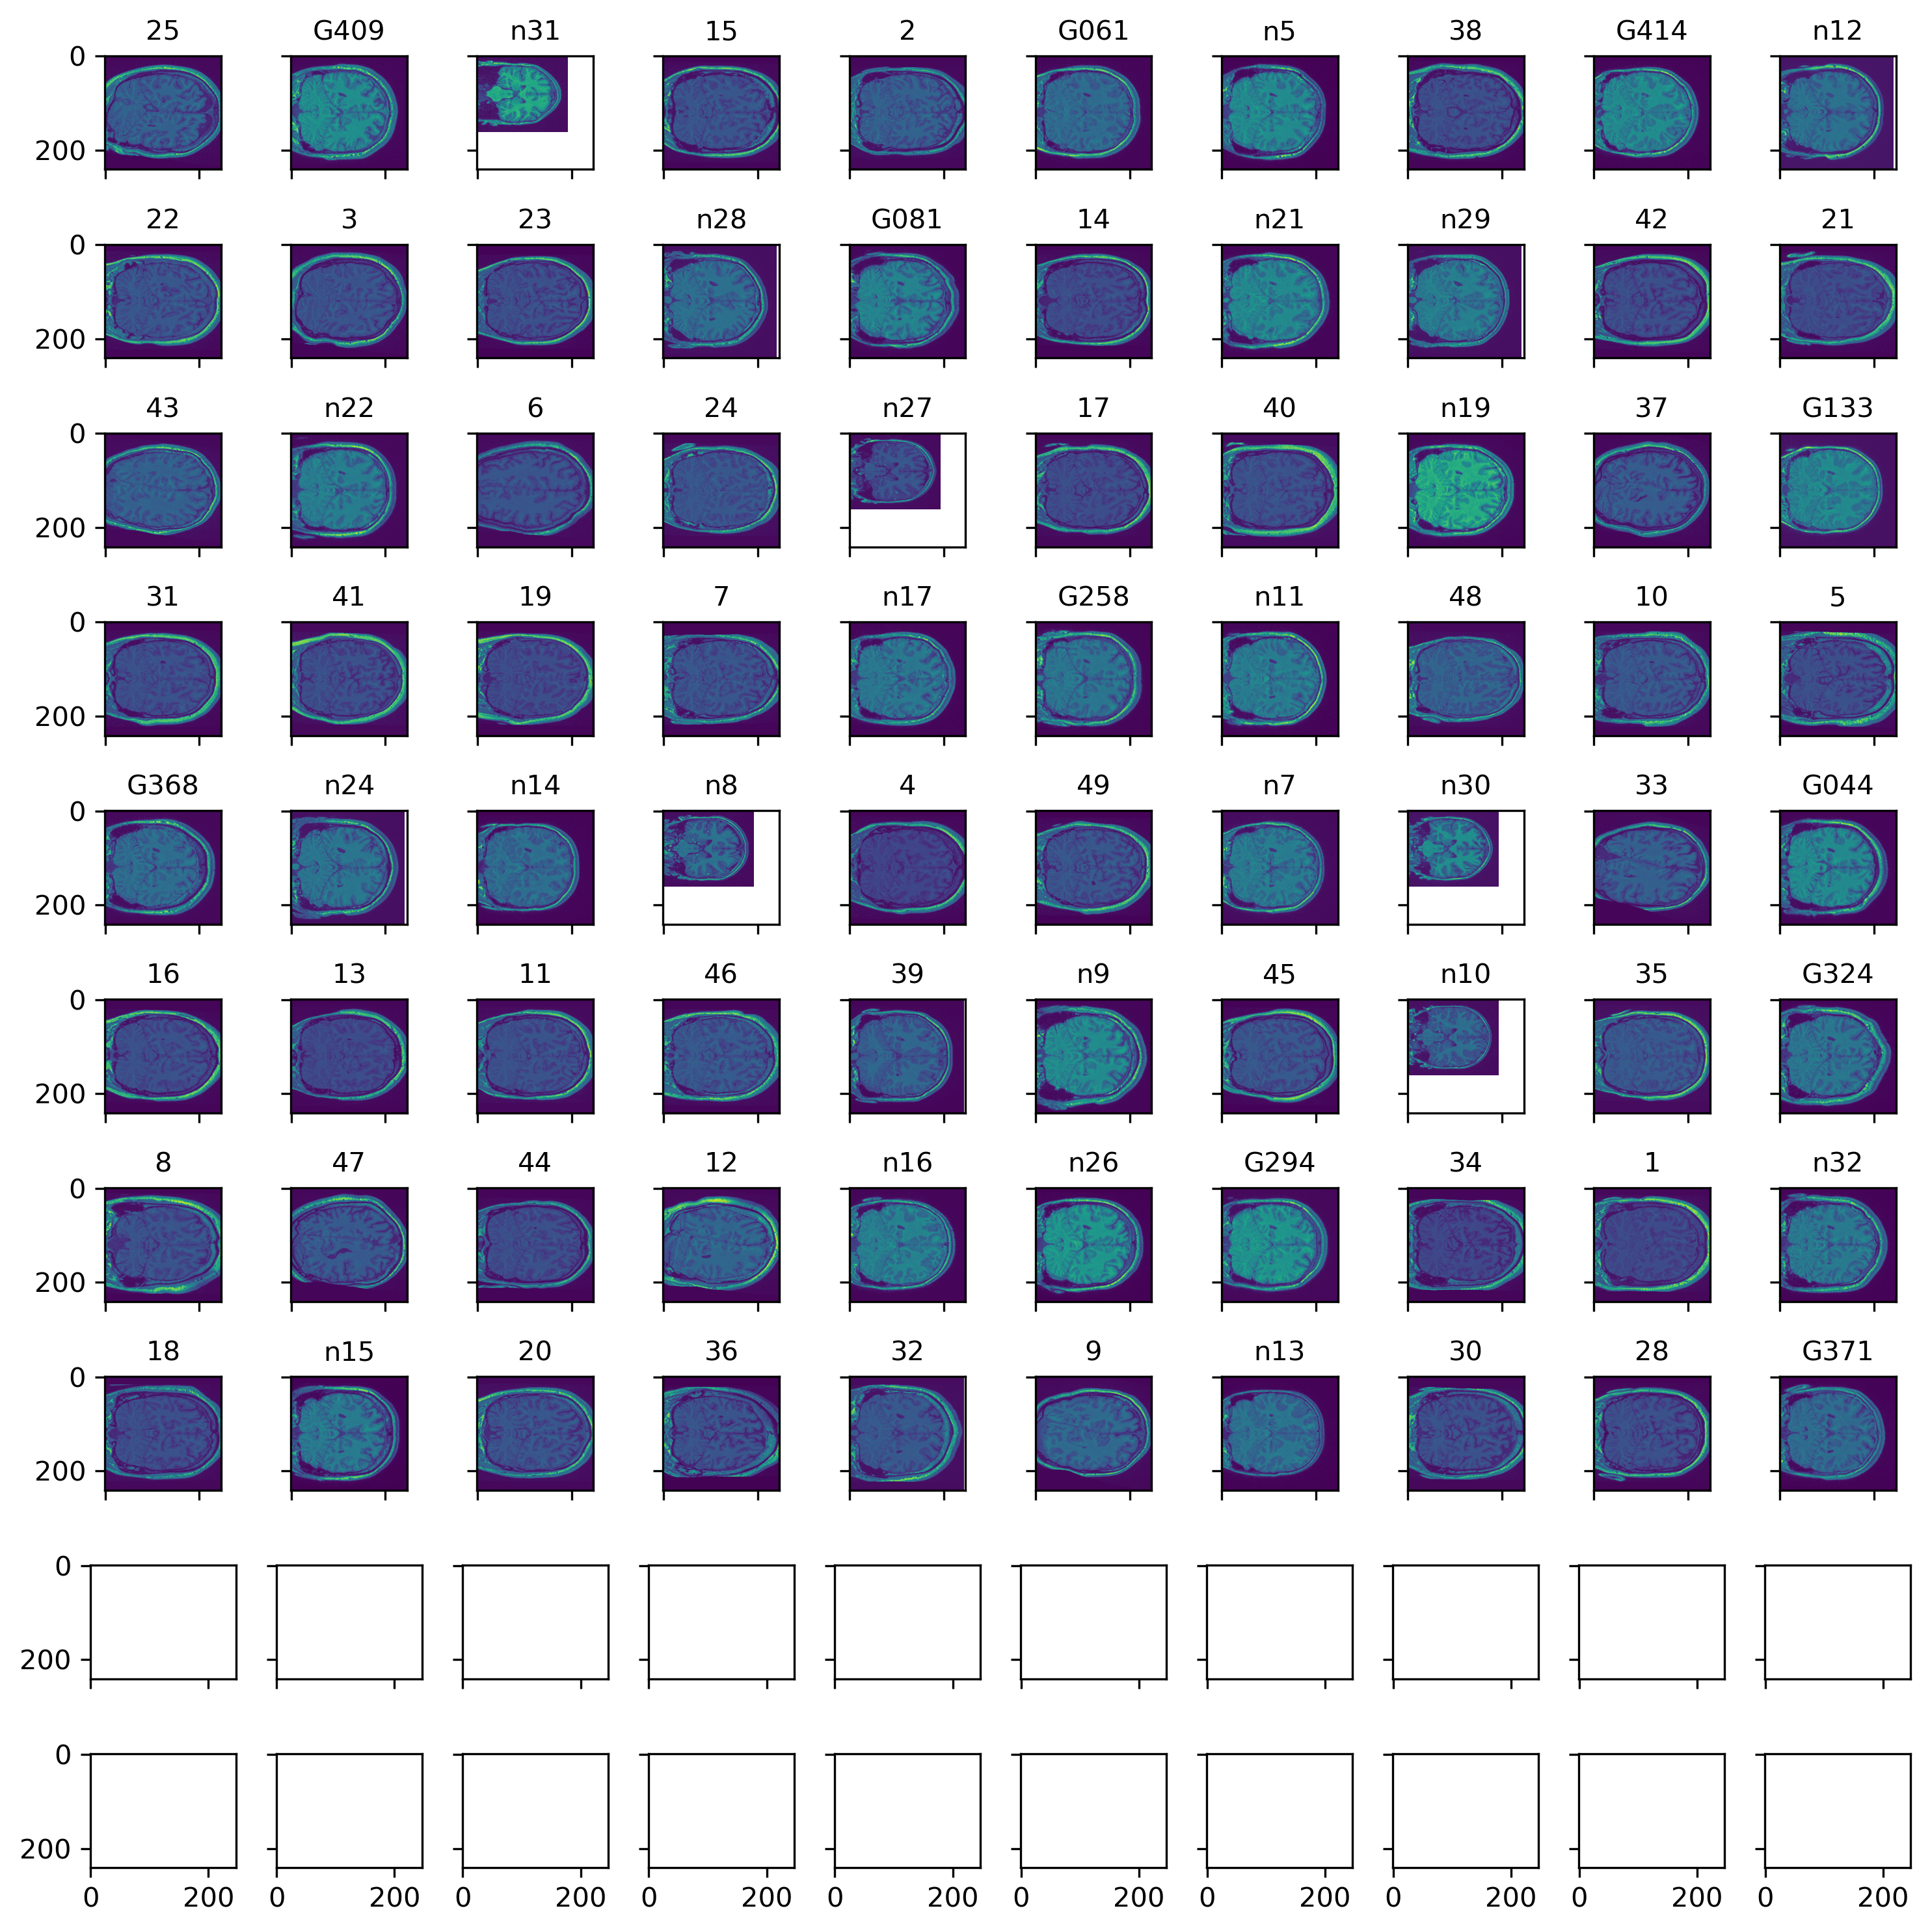

In [15]:
plt.ion()
step = steps[1]
fig, axes = plt.subplots(ncols=10, nrows=10, 
                         sharex=True, sharey=True, dpi=300, figsize=(10,10))
for i,ax in enumerate(axes.flatten()):
    try:
        ax.imshow(brains[step][i])
        ax.set_title(labels[i], fontsize=10)
    except:
        pass
plt.tight_layout()
plt.show()

# Connected components

In [16]:
label_info = defaultdict(dict)

for label, pdict in tqdm(paths_dict.items()):
    
    mask_tensor = nibabel.load(pdict['mask']).get_fdata() > 0
    mask_tensor = mask_tensor.astype(int)

    label_tensor = nibabel.load(pdict['label']).get_fdata() * mask_tensor
    label_tensor = np.array(label_tensor) > 0
    
    center,dx,dy,dz = patch_bbox_size(label_tensor)
    
    label_info[label]['d_s'] = [dx,dy,dz]
    label_info[label]['center'] = center


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:55<00:00,  2.20s/it]


In [24]:
patch_overlap = 33
if patch_overlap%2 !=0:
                patch_overlap += 1
patch_overlap

34

In [18]:
nonsingle_component_keys = {k for k,v in label_info.items() if len(v['cc3d'][0]) != 2}

In [19]:
nonsingle_component_keys

{'15', '2', '36', '5'}

In [21]:
np.save('metadata/label_info', label_info)

In [24]:
d_max = []
k_max = []
for k,v in labels_components.items():
    if 'd_s' in v.keys():
        d_max.append(max(v['d_s']))
        k_max.append(k)

In [27]:
k_max[np.argmax(d_max)]

'n20'

In [36]:
max(d_max)

90

In [28]:
labels_components['n20']

{'cc3d': [array([0, 1], dtype=uint16), array([56343243,    42657])],
 'd_s': [39, 90, 73],
 'center': array([ 73, 336, 111])}

In [30]:
brain,mask,label = load(paths_dict['n20'])

In [32]:
brain.shape, label.shape

((215, 558, 470), (215, 558, 470))

In [37]:
from skimage import morphology

In [45]:
label_e = morphology.binary_erosion(label).astype(int)

In [47]:
label_e.sum() / label.sum()

0.7763790233724829

In [46]:
plt.ioff()
camera = video(brain,
               label_e,
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation